In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.linalg import norm
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dreal, dcomplex

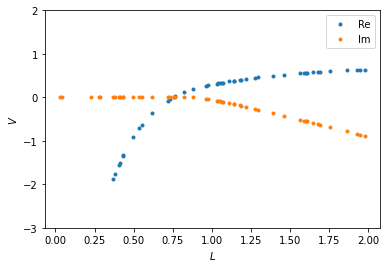

In [2]:
dataset = AdSBHDataset(N=50, threshold=0.0)
plt.plot(dataset.L.numpy(), dataset.V.real.numpy(), '.', label='Re')
plt.plot(dataset.L.numpy(), dataset.V.imag.numpy(), '.', label='Im')
plt.xlabel(f'$L$')
plt.ylabel(f'$V$')
plt.ylim(-3, 2)
plt.legend();

## Consistency check
Learnable parameters set to zero (standard BH).

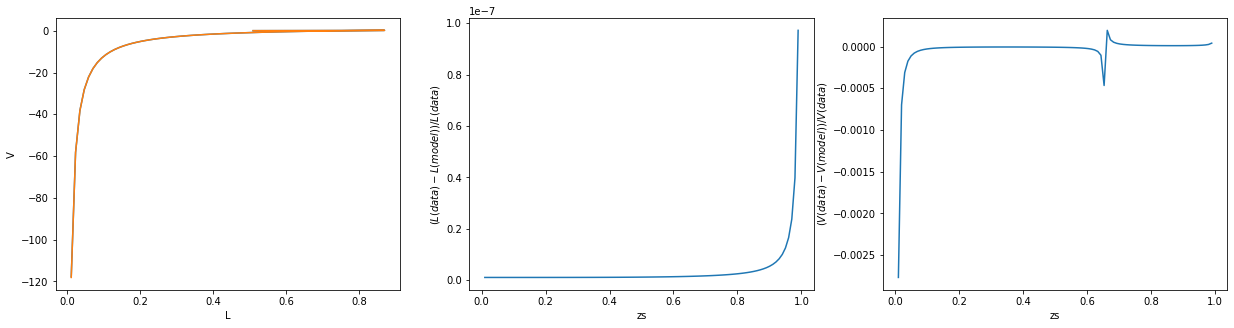

In [3]:
model = AdSBHNet(N=1)
model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
zs = np.linspace(0.01, 0.99, 100)
d_L = np.array([dataset.integrate_L(z).real for z in zs])
d_V = np.array([dataset.integrate_V(z).real for z in zs])
m_L = np.array([model.integrate_L(z).real.item() for z in zs])
m_V = np.array([model.integrate_V(z).real.item() for z in zs])
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(d_L, d_V)
axs[0].plot(m_L, m_V)
axs[0].set_xlabel('L')
axs[0].set_ylabel('V')
axs[1].plot(zs, (d_L-m_L)/d_L)
axs[1].set_xlabel('zs')
axs[1].set_ylabel(r'$(L(data)-L(model))/L(data)$')
axs[2].plot(zs, (d_V-m_V)/d_V)
axs[2].set_xlabel('zs')
axs[2].set_ylabel(r'$(V(data)-V(model))/V(data)$');

Agreement between dataset and model is reasonable with zero parameters. How about with some random parameters?

In [4]:
zsTest = [complex(0.9090315666604358,0.41673060503150205), complex(0.6287708163264771,0.1559688411675184), complex(0.9953260506741644,0.5277078670869617), complex(0.8521060104591969,0.5027588185369558), complex(0.5042854806928654,0.49630304825346894), complex(0.2535952633683096,0.7211932958489171), complex(0.5942400028353596,0.5823412725310948), complex(0.8147663498252915,0.04450827531849422), complex(0.009198300366664913,0.4552476552762066), complex(0.37446736033879957,0.6528079707687124)]
model = AdSBHNet(N=1)
model.a = nn.Parameter(torch.tensor([-0.43308637022216984], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.2578140045194215], dtype=dreal))
for zs in zsTest:
    print(f'{zs:.6f}\t{model.integrate_L(zs):.6f}\t{model.integrate_dL(zs):.6f}\t{model.integrate_V(zs):.6f}')

0.909032+0.416731j	1.279084+0.304967j	1.513808-0.899426j	0.757956-0.158004j
0.628771+0.155969j	0.761555+0.154710j	1.072988-0.265832j	0.116180+0.315518j
0.995326+0.527708j	1.517768+0.394461j	1.539215-1.014589j	0.929493-0.406683j
0.852106+0.502759j	1.264373+0.489792j	1.646546-0.845070j	0.980965-0.074910j
0.504285+0.496303j	0.679141+0.650467j	1.630502-0.144495j	1.082403+0.972164j
0.253595+0.721193j	0.225644+0.974641j	1.527085+0.549059j	2.050800+1.624107j
0.594240+0.582341j	0.853430+0.781756j	1.860413-0.277386j	1.344678+0.627021j
0.814766+0.044508j	0.869956+0.010819j	0.289396-0.320523j	0.192499+0.010894j
0.009198+0.455248j	-0.017199+0.554421j	1.230173+0.133093j	2.200441+2.906237j
0.374467+0.652808j	0.452233+0.911006j	1.733894+0.254421j	1.728301+1.330169j


Let's check that $a=b=0$ is a local minimum of the loss function

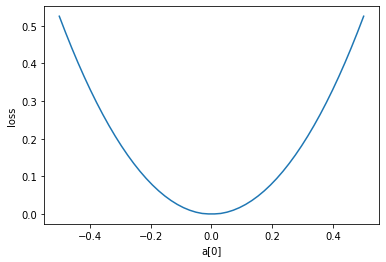

In [5]:
A = np.linspace(-0.5, 0.5, 50)
losses = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    loss = torch.mean(norm(model(dataset.L) - dataset.V))
    losses.append(loss.item())
plt.plot(A, losses)
plt.xlabel('a[0]')
plt.ylabel('loss');

Check that gradients agree with these results.

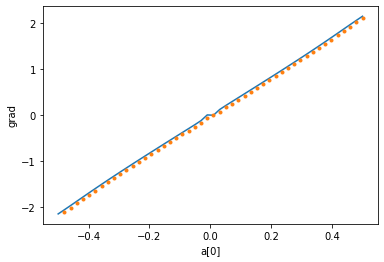

In [6]:
grads = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.zero_grad()
    loss = torch.mean(norm(model(dataset.L) - dataset.V))
    loss.backward()
    grads.append(model.a.grad[0].item())
plt.plot(A, grads)
plt.plot(A[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(A[1]-A[0]), '.')
plt.xlabel('a[0]')
plt.ylabel('grad');

Do the same check w.r.t. $b$.

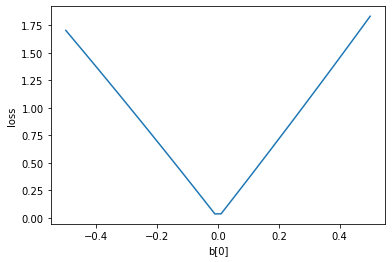

In [7]:
B = np.linspace(-0.5, 0.5, 50)
losses = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    loss = torch.mean(norm(model(dataset.L) - dataset.V))
    losses.append(loss.item())
plt.plot(B, losses)
plt.xlabel('b[0]')
plt.ylabel('loss');

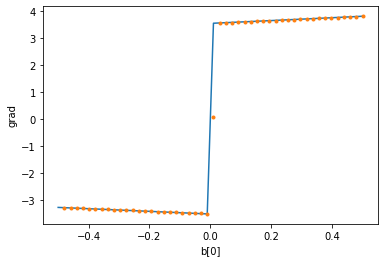

In [8]:
grads = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    model.zero_grad()
    loss = torch.mean(norm(model(dataset.L) - dataset.V))
    loss.backward()
    grads.append(model.b.grad[0].item())
plt.plot(B, grads)
plt.plot(B[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(B[1]-B[0]), '.')
plt.xlabel('b[0]')
plt.ylabel('grad');

## Training

In [17]:
model = AdSBHNet(N=4, std=1)
print(list(model.parameters()))
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer = torch.optim.RMSprop(model.parameters())
epochs = 100
a_vals, b_vals = [model.a.detach().numpy().copy()], [model.b.detach().numpy().copy()]
eps = 0.01

z = np.linspace(0, 0.95, 50)
fzInit = model.eval_f(z).detach().numpy()
gzInit = model.eval_g(z).detach().numpy()
fz0 = 1-z**4
gz0 = 1/fz0

try:
    for epoch in range(epochs):
        for L, V in loader:
            optimizer.zero_grad()
            V_pred = model(L)
            #loss = F.l1_loss(V_pred, V)
            loss = torch.mean(norm(V_pred - V)/(norm(V) + eps))
            loss.backward()
            a_vals.append(model.a.detach().numpy().copy())
            b_vals.append(model.b.detach().numpy().copy())
            optimizer.step()
        print(f'epoch={epoch:2d}, loss={loss.item():0.6f}')
except KeyboardInterrupt:
    print('Stopping.')

fz = model.eval_f(z).detach().numpy()
gz = model.eval_g(z).detach().numpy()

[Parameter containing:
tensor([1.1337, 0.7996, 0.9001, 0.6625], dtype=torch.float64,
       requires_grad=True), Parameter containing:
tensor([-1.1375, -0.1455,  0.0816, -0.1769], dtype=torch.float64,
       requires_grad=True)]
epoch= 0, loss=1.777468
epoch= 1, loss=1.662850
epoch= 2, loss=1.547671
epoch= 3, loss=1.430705
epoch= 4, loss=1.312499
epoch= 5, loss=1.193418
epoch= 6, loss=1.073738
epoch= 7, loss=0.953875
epoch= 8, loss=0.834342
epoch= 9, loss=0.715680
epoch=10, loss=0.598539
epoch=11, loss=0.484173
epoch=12, loss=0.375009
epoch=13, loss=0.273358
epoch=14, loss=0.180821
epoch=15, loss=0.098563
epoch=16, loss=0.037875
epoch=17, loss=0.056173
epoch=18, loss=0.073668
epoch=19, loss=0.066691
epoch=20, loss=0.047373
epoch=21, loss=0.032506
epoch=22, loss=0.030648
epoch=23, loss=0.029991
epoch=24, loss=0.031768
epoch=25, loss=0.034770
epoch=26, loss=0.034081
epoch=27, loss=0.031096
epoch=28, loss=0.028990
epoch=29, loss=0.028314
epoch=30, loss=0.028451
epoch=31, loss=0.028436
epo

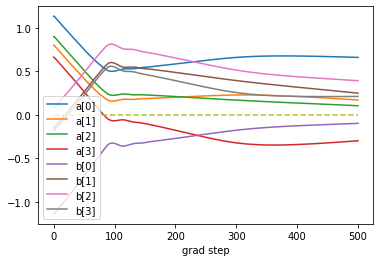

In [18]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.plot([0]*len(a_vals), '--')
plt.xlabel('grad step')
plt.legend();

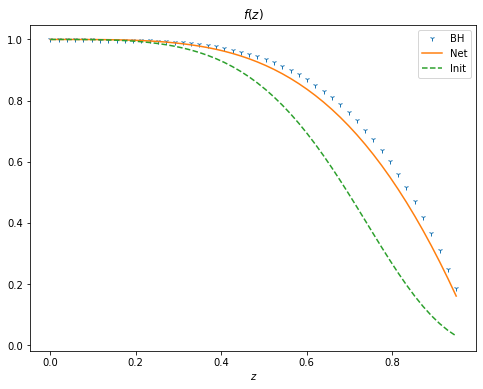

In [19]:
plt.subplots(figsize=(8, 6))
plt.plot(z, fz0, '1', label='BH')
plt.plot(z, fz, label='Net')
plt.plot(z, fzInit, '--', label='Init')
plt.title(f'$f(z)$')
plt.xlabel(f'$z$')
plt.legend();

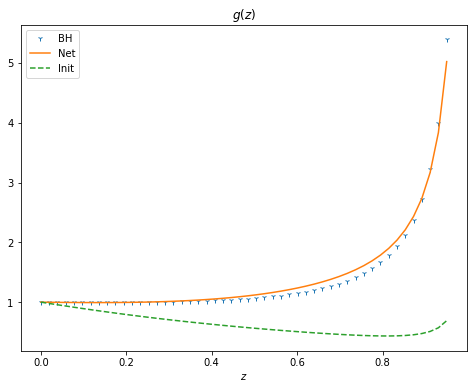

In [20]:
plt.subplots(figsize=(8, 6))
plt.plot(z, gz0, '1', label='BH')
plt.plot(z, gz, label='Net')
plt.plot(z, gzInit, '--', label='Init')
plt.title(f'$g(z)$')
plt.xlabel(f'$z$')
plt.legend();

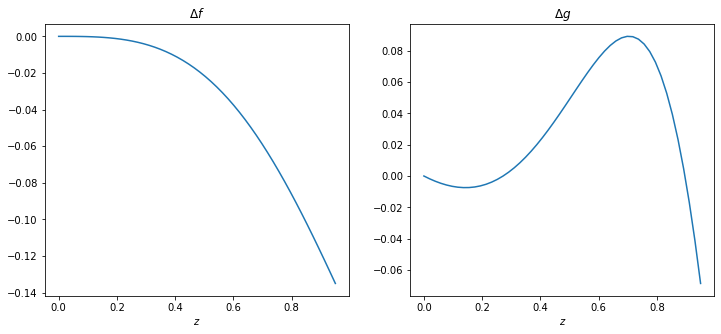

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(z, (fz-fz0)/fz0)
axs[0].set_title(f'$\Delta f$')
axs[0].set_xlabel(f'$z$')
axs[1].plot(z, (gz-gz0)/gz0)
axs[1].set_title(f'$\Delta g$')
axs[1].set_xlabel(f'$z$');

$$
\frac{1}{z^2} \left( -f(z) dt^2 + g(z) dz^2 + dx^2 + dy^2 \right)
$$

$$
f(z) = 1-z^4  \\
g(z) = 1/(1-z^4)
$$

$$
f(z) = (1-z^4)/e^{a(z)} \\
a(z) = \int_0^z (a_1 x + a_2 x^2 + \ldots )^2 dx
$$

$$
g(z) = e^{b(z)}/(1-z^4) \\
b(z) = b_1 z + b_2 z^2 + \ldots + (\sum_i b_i + a(1)) z^{N+1}
$$